# epitopepredict API basic usage

## Methodology

Predictors for each method inherit from the `Predictor` class and all implement a predict method for scoring a single sequence. This may wrap methods from other modules and/or call command line predictors. For example the `TepitopePredictor` uses the `mhcpredict.tepitope` module. This method should return a Pandas `DataFrame`. The `predictProteins` method is used for multiple proteins contained in a dataframe of sequences in a standard format. This is created from a genbank or fasta file (see examples below). For large numbers of sequences predictProteins you should provide a path so that the results are saved as each protein is completed to avoid memory issues, since many alleles might be called for each protein. Results are saved with one file per protein in csv format. Results can be loaded into the predictor individually or all together using the `load` method.

In [9]:
import os, math, time, pickle, subprocess
from importlib import reload
from collections import OrderedDict
import numpy as np
import pandas as pd
pd.set_option('display.width', 100)
import epitopepredict as ep
from epitopepredict import base, sequtils, tepitope, plotting, utilities, peptutils, mhclearn
from IPython.display import display, HTML, Image
%matplotlib inline
import matplotlib as mpl
import pylab as plt

In [10]:
#get preset alleles
m2_alleles = ep.get_preset_alleles('mhc2_supertypes')
m1_alleles = ep.get_preset_alleles('mhc1_supertypes')
print (m1_alleles)
print (m2_alleles)

['HLA-A*01:01', 'HLA-A*02:01', 'HLA-A*03:01', 'HLA-A*24:02', 'HLA-B*07:02', 'HLA-B*44:03']
['HLA-DRB1*01:01', 'HLA-DRB1*03:01', 'HLA-DRB1*04:01', 'HLA-DRB1*07:01', 'HLA-DRB1*08:01', 'HLA-DRB1*11:01', 'HLA-DRB1*13:01', 'HLA-DRB1*15:01']


In [11]:
data = mhclearn.get_training_set()
data.length.value_counts()
e = mhclearn.get_evaluation_set1()
print (e.length.value_counts())

9     25948
10     1376
8       763
11      488
15      154
12       71
14       15
13       13
26        3
16        2
30        1
24        1
Name: length, dtype: int64


## train models for basicmhc1 predictor before first use
this will be done automatically when you call the prediction methods if not run first

In [12]:
reload(mhclearn)
mhclearn.train_models(overwrite=True, alleles=['H-2-Kb'])#,'HLA-A*01:01','HLA-A*02:01','HLA-A*02:02','HLA-A*02:03','HLA-A*02:06'])

trained model: H-2-Kb 1611 9
trained model: H-2-Kb 374 10
trained model: H-2-Kb 140 11


In [13]:
a = mhclearn.get_allele_names()
print (len(a))

103


## predict random peptides

In [14]:
reload(base)
reload(mhclearn)
seqs = peptutils.create_random_sequences(1000)
print (seqs[:5])
df = pd.DataFrame(seqs,columns=['peptide'])
P = base.get_predictor('basicmhc1')

b = P.predict_peptides(df.peptide, alleles=m1_alleles, threads=8)

['YRFESPEYD', 'PIQHEQDEW', 'FIFHMECYF', 'CDGDKSNPV', 'YAQRPYPNC']


## results are returned as dataframes, sorted by score

In [15]:
print (b[:5])

     peptide  pos  log50k   score  name       allele  rank
0  NTEKVALQY  270  0.8211    6.93  temp  HLA-A*01:01   1.0
1  YMAKFSALY  603  0.7968    9.01  temp  HLA-A*01:01   2.0
2  TTCMYQTRY   58  0.7505   14.87  temp  HLA-A*01:01   3.0
3  YLEYCDMPY  538  0.7310   18.37  temp  HLA-A*01:01   4.0
4  WTEFTVIQF  631  0.4376  439.24  temp  HLA-A*01:01   5.0


## predict from a sequence

In [16]:
seq = 'MTDDPGSGFTTVWNAVVSELNGDPKVDDGP'
b = P.predict_sequences(seq, alleles=m1_alleles, length=9)
b

predictions done for 1 sequences in 6 alleles


,allele,log50k,name,peptide,pos,rank,score
0,HLA-A*01:01,0.3769,0,MTDDPGSGF,1,1.0,847.09
8,HLA-A*01:01,0.2390,0,FTTVWNAVV,9,2.0,3766.31
16,HLA-A*01:01,0.1480,0,VSELNGDPK,17,3.0,10081.44
1,HLA-A*01:01,0.1066,0,TDDPGSGFT,2,4.0,15778.29
12,HLA-A*01:01,0.1062,0,WNAVVSELN,13,5.0,15846.72
...,...,...,...,...,...,...,...
15,HLA-B*44:03,0.1032,0,VVSELNGDP,16,13.0,16369.53
16,HLA-B*44:03,0.1032,0,VSELNGDPK,17,13.0,16369.53
19,HLA-B*44:03,0.1032,0,LNGDPKVDD,20,13.0,16369.53
20,HLA-B*44:03,0.1032,0,NGDPKVDDG,21,13.0,16369.53


## predict n-mers from multiple protein sequence
This example loads protein sequences from mycobacterium tuberculosis from a genbank file

In [17]:
#load protein sequences into a dataframe
prots = ep.genbank_to_dataframe(base.mtb_genome, cds=True)
prots[:5]

,type,protein_id,locus_tag,gene,db_xref,product,note,translation,pseudo,pseudogene,start,end,strand,length,order
2,CDS,CCP42723.1,Rv0001,dnaA,GI:444893470,Chromosomal replication initiator protein DnaA,"Rv0001, (MT0001, MTV029.01, P49993), len: 507 ...",MTDDPGSGFTTVWNAVVSELNGDPKVDDGPSSDANLSAPLTPQQRA...,NaN,NaN,0,1524,1,507,1
4,CDS,CCP42724.1,Rv0002,dnaN,GI:444893471,DNA polymerase III (beta chain) DnaN (DNA nucl...,"Rv0002, (MTV029.02, MTCY10H4.0), len: 402 aa. ...",MDAATTRVGLTDLTFRLLRESFADAVSWVAKNLPARPAVPVLSGVL...,NaN,NaN,2051,3260,1,402,2
6,CDS,CCP42725.1,Rv0003,recF,GI:444893472,DNA replication and repair protein RecF (singl...,"Rv0003, (MTCY10H4.01), len: 385 aa. RecF, DNA ...",MYVRHLGLRDFRSWACVDLELHPGRTVFVGPNGYGKTNLIEALWYS...,NaN,NaN,3279,4437,1,385,3
8,CDS,CCP42726.1,Rv0004,NaN,GI:444893473,Conserved hypothetical protein,"Rv0004, (MTCY10H4.02), len: 187 aa. Conserved ...",MTGSVDRPDQNRGERSMKSPGLDLVRRTLDEARAAARARGQDAGRG...,NaN,NaN,4433,4997,1,187,4
10,CDS,CCP42727.1,Rv0005,gyrB,GI:444893474,DNA gyrase (subunit B) GyrB (DNA topoisomerase...,"Rv0005, (MTCY10H4.03), len: 675 aa. GyrB, DNA ...",MAAQKKKAQDEYGAASITILEGLEAVRKRPGMYIGSTGERGLHHLI...,NaN,NaN,5239,7267,1,675,5


In [43]:
proteins = ['Rv3615c','Rv3875','Rv1886c']
P1 = base.get_predictor('basicmhc1')
binders = P1.predict_sequences(prots, names=proteins, alleles=m1_alleles, length=9, threads=8)

predictions done for 3 sequences in 6 alleles


In [44]:
binders.head()

,allele,log50k,name,peptide,pos,rank,score
169,HLA-A*01:01,0.6958,Rv1886c,SSAMILAAY,170,1.0,26.88
93,HLA-A*01:01,0.6623,Rv1886c,NTPAFEWYY,94,2.0,38.62
114,HLA-A*01:01,0.6137,Rv1886c,QSSFYSDWY,115,3.0,65.34
118,HLA-A*01:01,0.5303,Rv1886c,YSDWYSPAC,119,4.0,161.10
222,HLA-A*01:01,0.3067,Rv1886c,SSDPAWERN,223,5.0,1810.49


## get promiscuous binders - those peptides above the cutoff for at least n alleles

In [46]:
pb1 = P1.promiscuous_binders(n=2, cutoff=5, cutoff_method='rank')
pb1[:5]

/home/damien/gitprojects/epitopepredict/epitopepredict/base.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binders['core'] = binders.peptide


,peptide,pos,name,alleles,core,score,mean,median_rank
70,VTSIHSLLD,22,Rv3875,3,VTSIHSLLD,3347.32,5387.370,3.0
24,HTAGVDLAK,70,Rv3615c,2,HTAGVDLAK,100.19,4114.370,1.5
59,SSAMILAAY,170,Rv1886c,2,SSAMILAAY,26.88,1057.660,2.5
61,SVAITHGPY,39,Rv3615c,2,SVAITHGPY,1713.29,2833.760,2.5
4,AIQGNVTSI,17,Rv3875,2,AIQGNVTSI,1410.10,3128.155,3.0


## run other predictors

In [ ]:
reload(base)
P2 = base.get_predictor('netmhcpan')
P2.predict_sequences(prots, names=proteins, alleles=m1_alleles, length=9, threads=8)

In [35]:
reload(base)
P3 = base.get_predictor('mhcflurry')
P3.predict_sequences(prots, names=proteins, alleles=m1_alleles, length=9, verbose=True)

name                      allele           top peptide        score
Rv3615c                   HLA-A*01:01      QFNDTLNVY          804.3360154563782 
Rv3615c                   HLA-A*02:01      ALGSSLHTA          31.665793785308146 
Rv3615c                   HLA-A*03:01      HTAGVDLAK          87.12363499233405 
Rv3615c                   HLA-A*24:02      VYLTAHNAL          39.63350826881655 
Rv3615c                   HLA-B*07:02      LAKSLRIAA          329.70873449497435 
Rv3615c                   HLA-B*44:03      SEADEAWRK          636.6618996905046 
Rv3875                    HLA-A*01:01      LLDEGKQSL          591.3214266532199 
Rv3875                    HLA-A*02:01      LLDEGKQSL          38.908956492412095 
Rv3875                    HLA-A*03:01      EAYQGVQQK          228.50292817379588 
Rv3875                    HLA-A*24:02      AYQGVQQKW          44.24060698145829 
Rv3875                    HLA-B*07:02      KWDATATEL          133.10928532097978 
Rv3875                    HLA-B*44:0

,allele,mhcflurry_affinity,mhcflurry_affinity_percentile,mhcflurry_presentation_percentile,mhcflurry_presentation_score,mhcflurry_processing_score,name,peptide,pos,rank,score
49,HLA-A*01:01,804.336015,0.745250,2.261060,0.146280,0.115985,Rv3615c,QFNDTLNVY,50,1.0,804.336015
50,HLA-A*01:01,899.918141,0.800625,1.832636,0.200953,0.255270,Rv3615c,FNDTLNVYL,51,2.0,899.918141
38,HLA-A*01:01,1196.684045,0.945000,2.587527,0.119575,0.159381,Rv3615c,SVAITHGPY,39,3.0,1196.684045
86,HLA-A*01:01,1998.165524,1.246125,5.449429,0.046052,0.007781,Rv3615c,YSEADEAWR,87,4.0,1998.165524
88,HLA-A*01:01,4983.969685,2.072250,4.047908,0.065828,0.365604,Rv3615c,EADEAWRKA,89,5.0,4983.969685
...,...,...,...,...,...,...,...,...,...,...,...
18,HLA-B*44:03,32259.021322,40.329625,99.286603,0.003155,0.001343,Rv3875,QGNVTSIHS,19,83.0,32259.021322
52,HLA-B*44:03,32465.619160,46.498875,99.286603,0.003217,0.008599,Rv3875,GVQQKWDAT,53,84.0,32465.619160
35,HLA-B*44:03,32688.080557,46.498875,99.286603,0.003116,0.001443,Rv3875,LTKLAAAWG,36,85.0,32688.080557
37,HLA-B*44:03,32939.261826,53.881750,99.286603,0.003113,0.003266,Rv3875,KLAAAWGGS,38,86.0,32939.261826


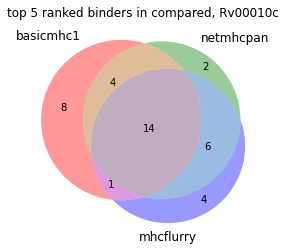

In [36]:
prot='Rv3615c'
b1 = P1.get_binders(cutoff=5,name=prot,cutoff_method='rank')
b2 = P2.get_binders(cutoff=5,name=prot,cutoff_method='rank')
b3 = P3.get_binders(cutoff=5,name=prot,cutoff_method='rank')
from matplotlib_venn import venn3
ax = venn3((set(b1.peptide),set(b2.peptide),set(b3.peptide)), set_labels = ('basicmhc1','netmhcpan','mhcflurry'))
plt.title('top 5 ranked binders in compared, Rv00010c')
plt.savefig('basicmhc1_binders_compared.jpg',dpi=150)

/home/damien/gitprojects/epitopepredict/epitopepredict/base.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binders['core'] = binders.peptide
/home/damien/gitprojects/epitopepredict/epitopepredict/base.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binders['core'] = binders.peptide


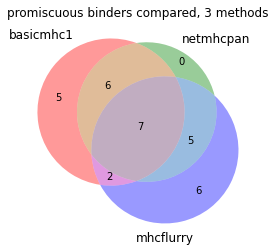

In [37]:
pb1 = P1.promiscuous_binders(n=2,cutoff=10,limit=10,cutoff_method='rank')
pb2 = P2.promiscuous_binders(n=2,cutoff=10,limit=10,cutoff_method='rank')
pb3 = P3.promiscuous_binders(n=2,cutoff=10,limit=10,cutoff_method='rank')
ax = venn3((set(pb1.peptide),set(pb2.peptide),set(pb3.peptide)), set_labels = ('basicmhc1','netmhcpan','mhcflurry'))
plt.title('promiscuous binders compared, 3 methods')
plt.savefig('basicmhc1_prom_binders_compared.jpg',dpi=150)

## plot binders in a protein sequence

['Rv3615c', 'Rv3875']


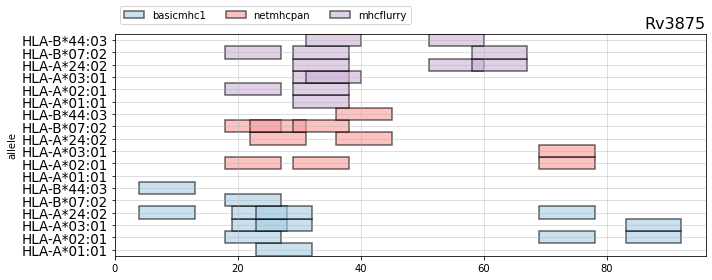

In [47]:
reload(plotting)
#get names of proteins stored in results of predictor
print (P2.get_names())
ax = plotting.plot_tracks([P1,P2,P3],name='Rv3875',cutoff=5,cutoff_method='rank',n=2,legend=True)
plt.tight_layout()
plt.savefig('comparison_rv3875.png',dpi=150)
#ax = plotting.plot_binder_map(P1,name='Rv0011c',cutoff=10)
#plt.savefig('mhc_rv0011c_map.png',dpi=150)

In [50]:
reload(plotting)
from bokeh.io import show, output_notebook
output_notebook()
p = plotting.bokeh_plot_tracks([P1,P2,P3],name='Rv0008c',cutoff=10,cutoff_method='rank',n=2,width=800)
show(p)

Loading BokehJS ...